Import necessary modules.

In [31]:
!pip install imutils

import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import parameters
import numpy as np
import re
import imutils

DATA_PATH = "input/train_v2/"

In [37]:
# Function to decode the Run-Length Encoding (RLE) label
def rle_decode(label,image_size=768):
    size = image_size*image_size
    mask = np.zeros(size)
    label = re.sub(r'[^0-9\s]', '', label)
    label = label.split()

    for index in range(0, len(label), 2):
        start_pixel = int(label[index])
        end_pixel = int(label[index]) + int(label[index+1])
        mask[start_pixel:end_pixel] = 1

    mask = np.reshape(mask, (image_size, image_size))

    mask = cv.resize(mask, (image_size, image_size), interpolation=cv.INTER_NEAREST)
    mask = cv.flip(mask, 1)
    mask = imutils.rotate(mask, 90)

    mask = np.reshape(mask, (image_size, image_size, 1))

    return mask

Load dataset into data variable and
display the first 10 rows of the loaded dataset.

In [3]:
ds_train = pd.read_csv('input/train_v2/train_ship_segmentations_v2.csv')

ds_train.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Lets see basic information of our dataset train .csv file.

In [7]:
#Basic information
ds_train.info()

#Describe the data
ds_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


Print columns in dataset

In [8]:
#column to list 
ds_train.columns.tolist()


['ImageId', 'EncodedPixels']

Check number of duplicated value in train .csv dataset.

In [9]:
#Find the duplicates
ds_train.duplicated(subset="ImageId").sum()

39167

Check unique value in each column:

In [10]:
#unique values in "ImageId"
ds_train['ImageId'].unique()

array(['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', ...,
       'ffff6e525.jpg', 'ffffc50b4.jpg', 'ffffe97f3.jpg'], dtype=object)

In [11]:
#unique values in "EncodedPixels"
ds_train['EncodedPixels'].unique()

array([nan,
       '264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 

In [13]:
#number of unique values in train dataframe
ds_train.nunique()


ImageId          192556
EncodedPixels     81722
dtype: int64

Finding null values in train dataset

In [14]:
#Find null values
ds_train.isnull().sum()

ImageId               0
EncodedPixels    150000
dtype: int64

Lets know datatype of our training dataset

In [15]:
#Datatypes
ds_train.dtypes

ImageId          object
EncodedPixels    object
dtype: object

Now we check the shape of the dataset.

In [16]:
print('Dataset shape:', ds_train.shape)

Dataset shape: (231723, 2)


Count the number of images with and without ships.

In [18]:

ship_counts = ds_train['EncodedPixels'].notnull().value_counts()
print('Number of images with and without ships:')
ship_counts

Number of images with and without ships:


EncodedPixels
False    150000
True      81723
Name: count, dtype: int64

Print first 10 image sizes to understand with what size we need to work.

In [48]:
image_id = ds_train['ImageId'].values
count = 0
all_img_shapes = []

for image_name in image_id:
    if count == 1000:
        break
    count += 1
    img = cv.imread(DATA_PATH + image_name)
    all_img_shapes.append(img.shape)
    # print(f'image number {count} has size = {img.shape}')


# get unique value from list by using set
list_set = set(all_img_shapes)
# convert the set to the list
print('The shape of images', list(list_set))


[(768, 768, 3)]


Visualize example images with ships and mask.

Text(0.5, 1.0, 'Fourth mask')

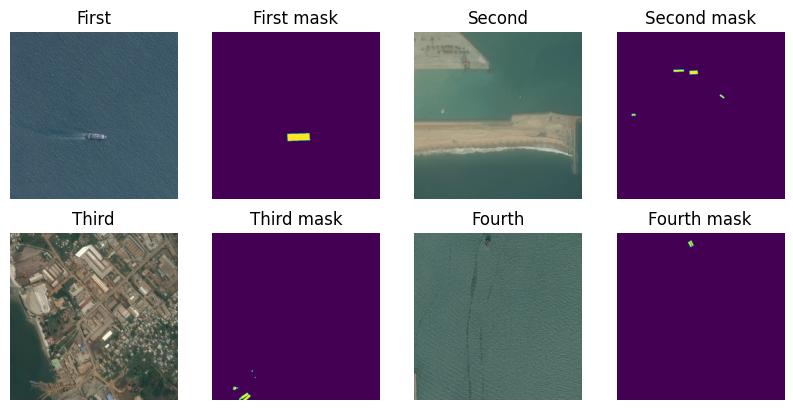

In [44]:

train_df = ds_train.head(100)
train_df = train_df.dropna()
train_df = train_df.groupby('ImageId')['EncodedPixels'].agg(' '.join).reset_index(name='EncodedPixels')
labels = train_df['EncodedPixels'].values
labels = np.array(list(map(rle_decode, labels)))

ship_images = train_df['ImageId'].values

# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 4
columns = 4

# reading images
Image1 = cv.cvtColor(cv.imread(DATA_PATH + ship_images[0]),cv.COLOR_BGR2RGB)
mask1 = labels[0]
Image2 = cv.cvtColor(cv.imread(DATA_PATH + ship_images[1]),cv.COLOR_BGR2RGB)
mask2 = labels[1]
Image3 = cv.cvtColor(cv.imread(DATA_PATH + ship_images[2]),cv.COLOR_BGR2RGB)
mask3 = labels[2]
Image4 = cv.cvtColor(cv.imread(DATA_PATH + ship_images[3]),cv.COLOR_BGR2RGB)
mask4 = labels[3]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(mask1)
plt.axis('off')
plt.title("First mask")
  

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(mask2)
plt.axis('off')
plt.title("Second mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(mask3)
plt.axis('off')
plt.title("Third mask")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Fourth")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(mask4)
plt.axis('off')
plt.title("Fourth mask")